[View in Colaboratory](https://colab.research.google.com/gist/alextp/5cfcffd408bd5103f5ae747bc97ab0b5/tfe-workshop-models.ipynb)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

# Variables

TensorFlow variables are useful to store the state in your program. They are integrated with other parts of the API (taking gradients, checkpointing, graph functions).

In [2]:
# Creating variables
v = tf.Variable(1.0)
v

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

In [3]:
v.assign_add(1.0)
v

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>

# Layers: common sets of useful operations

Most of the time when writing code for machine learning models you want to operate at a higher level of abstraction than individual operations and manipulation of individual variables.

Many machine learning models are expressible as the composition and stacking of relatively simple layers, and TensorFlow provides both a set of many common layers as a well as easy ways for you to write your own application-specific layers either from scratch or as the composition of existing layers.

TensorFlow includes the full [Keras](https://keras.io) API in the tf.keras package, and the Keras layers are very useful when building your own models.


In [4]:
# In the tf.keras.layers package, layers are objects. To construct a layer,
# simply construct the object. Most layers take as a first argument the number
# of output dimensions / channels.
layer = tf.keras.layers.Dense(100)

# The number of input dimensions is often unnecessary, as it can be inferred
# the first time the layer is used, but it can be provided if you want to 
# specify it manually, which is useful in some complex models.
layer = tf.keras.layers.Dense(10, input_shape=(None, 5))


In [5]:
layer(tf.zeros([2, 2]))

<tf.Tensor: id=43, shape=(2, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [6]:
layer.variables

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float32, numpy=
 array([[-0.42494273, -0.2067694 ,  0.4519381 ,  0.6842533 ,  0.04131705,
          0.70547956,  0.4021917 , -0.5939298 , -0.5671462 ,  0.5586321 ],
        [ 0.3709975 , -0.64126074, -0.5386696 , -0.42212513,  0.6550072 ,
          0.70081085,  0.08859557, -0.30801034, -0.31450653,  0.02522504]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

The full list of pre-existing layers can be seen in [the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers). It includes Dense (a fully-connected layer),
Conv2D, LSTM, BatchNormalization, Dropout, and many others.

# Models: composing layers

Many interesting layer-like things in machine learning models are implemented by composing existing layers. For example, each residual block in a resnet is a composition of convolutions, batch normalizations, and a shortcut.

The main class used when creating a layer-like thing which contains other layers is tf.keras.Model. Implementing one is done by inheriting from tf.keras.Model.


In [7]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)
  
block = ResnetIdentityBlock(1, [1, 2, 3])
print(block(tf.zeros([1, 2, 3, 3])))
print([x.name for x in block.variables])

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]], shape=(1, 2, 3, 3), dtype=float32)
['resnet_identity_block/conv2d/kernel:0', 'resnet_identity_block/conv2d/bias:0', 'resnet_identity_block/batch_normalization/gamma:0', 'resnet_identity_block/batch_normalization/beta:0', 'resnet_identity_block/conv2d_1/kernel:0', 'resnet_identity_block/conv2d_1/bias:0', 'resnet_identity_block/batch_normalization_1/gamma:0', 'resnet_identity_block/batch_normalization_1/beta:0', 'resnet_identity_block/conv2d_2/kernel:0', 'resnet_identity_block/conv2d_2/bias:0', 'resnet_identity_block/batch_normalization_2/gamma:0', 'resnet_identity_block/batch_normalization_2/beta:0', 'resnet_identity_block/batch_normalization/moving_mean:0', 'resnet_identity_block/batch_normalization/moving_variance:0', 'resnet_identity_block/batch_normalization_1/moving_mean:0', 'resnet_identity_block/batch_normalization_1/moving_variance:0', 'resnet_identity_block/batch_normalization_2

Much of the time, however, models which compose many layers simply call one layer after the other. This can be done in very little code using tf.keras.Sequential

In [8]:
 my_seq = tf.keras.Sequential([tf.keras.layers.Conv2D(1, (1, 1)),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(2, 1, 
                                                      padding='same'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(3, (1, 1)),
                               tf.keras.layers.BatchNormalization()])
my_seq(tf.zeros([1, 2, 3, 3]))


<tf.Tensor: id=493, shape=(1, 2, 3, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)>

## Exercise!

Make a simple convolutional neural network model, useful for things such as MNIST which don't need too many parameters. A sequence of two or three convolutions with small output channels (say, 32 and 64) plus one or two fully connected layers is probably enough.

The input shape should be [batch_size, 28, 28, 1].

In [9]:
# TODO: Implement a convolutional model as described above, and assign it to
# model.
model = tf.keras.Sequential([
    
])

In [10]:
#@title Click to see the answer

max_pool = tf.keras.layers.MaxPooling2D(
      (2, 2), (2, 2), padding='same')
  # The model consists of a sequential chain of layers, so tf.keras.Sequential
  # (a subclass of tf.keras.Model) makes for a compact description.
model = tf.keras.Sequential(
      [
          tf.keras.layers.Conv2D(
              32,
              5,
              padding='same',
              activation=tf.nn.relu),
          max_pool,
          tf.keras.layers.Conv2D(
              64,
              5,
              padding='same',
              activation=tf.nn.relu),
          max_pool,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1024, activation=tf.nn.relu),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(10)
      ])

model(tf.zeros([1, 28, 28, 1]))

<tf.Tensor: id=625, shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

# Stop here for now

# Training

When eager execution is enabled, you can write Pythonic training loops. Simply

1. load your data into a `tf.data.Dataset`, which lets you construct functional pipelines for processing, shuffling, and batching your data,
2. iterate over the dataset using a Python `for` loop, and
3. perform an optimization step in the body of your `for` loop.

This workflow is exemplified in the following exercise.



## Exercise!

In this exercise, you'll train the convolutional model you implemented for the previous exericse on the MNIST dataset. 

In [11]:
#@title Utilities for downloading MNIST data (double-click to show code)
import gzip
import os
import tempfile
from six.moves import urllib
import shutil

import numpy as np

def read32(bytestream):
  """Read 4 bytes from bytestream as an unsigned 32-bit integer."""
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def check_image_file_header(filename):
  """Validate that filename corresponds to images for the MNIST dataset."""
  with tf.gfile.Open(filename, 'rb') as f:
    magic = read32(f)
    read32(f)  # num_images, unused
    rows = read32(f)
    cols = read32(f)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST file %s' % (magic,
                                                                     f.name))
    if rows != 28 or cols != 28:
      raise ValueError(
          'Invalid MNIST file %s: Expected 28x28 images, found %dx%d' %
          (f.name, rows, cols))


def check_labels_file_header(filename):
  """Validate that filename corresponds to labels for the MNIST dataset."""
  with tf.gfile.Open(filename, 'rb') as f:
    magic = read32(f)
    read32(f)  # num_items, unused
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST file %s' % (magic,
                                                                     f.name))
      
def download(directory, filename):
  """Download (and unzip) a file from the MNIST dataset if not already done."""
  filepath = os.path.join(directory, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(directory):
    tf.gfile.MakeDirs(directory)
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  url = 'https://storage.googleapis.com/cvdf-datasets/mnist/' + filename + '.gz'
  _, zipped_filepath = tempfile.mkstemp(suffix='.gz')
  print('Downloading %s to %s' % (url, zipped_filepath))
  urllib.request.urlretrieve(url, zipped_filepath)
  with gzip.open(zipped_filepath, 'rb') as f_in, \
      tf.gfile.Open(filepath, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
  os.remove(zipped_filepath)
  return filepath


def dataset(directory, images_file, labels_file):
  """Download and parse MNIST dataset."""

  images_file = download(directory, images_file)
  labels_file = download(directory, labels_file)

  check_image_file_header(images_file)
  check_labels_file_header(labels_file)

  def decode_image(image):
    # Normalize from [0, 255] to [0.0, 1.0]
    image = tf.decode_raw(image, tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [28, 28, 1])
    return image / 255.0

  def decode_label(label):
    label = tf.decode_raw(label, tf.uint8)  # tf.string -> [tf.uint8]
    label = tf.reshape(label, [])  # label is a scalar
    return tf.to_int32(label)

  images = tf.data.FixedLengthRecordDataset(
      images_file, 28 * 28, header_bytes=16).map(decode_image)
  labels = tf.data.FixedLengthRecordDataset(
      labels_file, 1, header_bytes=8).map(decode_label)
  return tf.data.Dataset.zip((images, labels))


def get_training_data(directory):
  """tf.data.Dataset object for MNIST training data."""
  return dataset(directory, 'train-images-idx3-ubyte',
                 'train-labels-idx1-ubyte').take(1024)

def get_test_data(directory):
  """tf.data.Dataset object for MNIST test data."""
  return dataset(directory, 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

In [12]:
# Don't forget to run the cell above!
training_data = get_training_data("/tmp/mnist/train")
test_data = get_test_data("/tmp/mnist/test")

Fill in the implementation of `train_one_epoch` below and run the cell to train your model. 

In [14]:
EPOCHS = 5
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.5)

def loss_fn(logits, labels):
  return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=tf.squeeze(logits), labels=labels))

def train_one_epoch(model, training_data, optimizer):
  # TODO: Implement an optimization step and return the average loss.
  #
  # Hint: Use `tf.GradientTape` to compute the gradient of the loss, and use
  # `optimizer.apply_gradients` to update the model's variables, which are
  #  accessible as `model.variables`
  average_loss = tfe.metrics.Mean('loss')
  for images, labels in training_data.shuffle(buffer_size=10000).batch(64):
    pass
  return average_loss.result()

for epoch in range(EPOCHS):
  loss = train_one_epoch(model, training_data, optimizer)
  print("Average loss after epoch %d: %.4f" % (epoch, loss))

Average loss after epoch 0: 2.2847
Average loss after epoch 1: 2.2305
Average loss after epoch 2: 2.1334
Average loss after epoch 3: 1.9115
Average loss after epoch 4: 1.4285


In [15]:
#@title Double-click to see a solution.
EPOCHS = 5
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.5)

def _loss_fn(logits, labels):
  return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=tf.squeeze(logits), labels=labels))

def _train_one_epoch(model, training_data):
  average_loss = tfe.metrics.Mean("loss")
  for images, labels in training_data.shuffle(buffer_size=10000).batch(64):
    with tf.GradientTape() as tape:
      logits = model(images, training=True)
      loss = _loss_fn(logits, labels)
    average_loss(loss)
    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
  return average_loss.result()
   
for epoch in range(EPOCHS):
  loss = _train_one_epoch(model, training_data)
  print("Average loss after epoch %d: %.4f" % (epoch, loss))

Average loss after epoch 0: 1.0563
Average loss after epoch 1: 0.8013
Average loss after epoch 2: 0.6306
Average loss after epoch 3: 0.5543
Average loss after epoch 4: 0.5037


Run the below cell to qualitatively evaluate your model. Note how eager execution interoperates seamlessly with `matplotlib`.

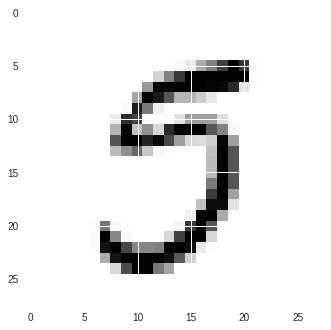

Prediction: 5


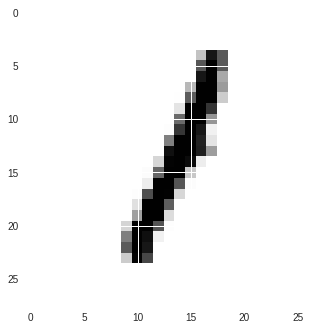

Prediction: 1


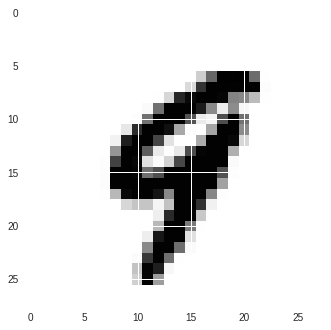

Prediction: 4


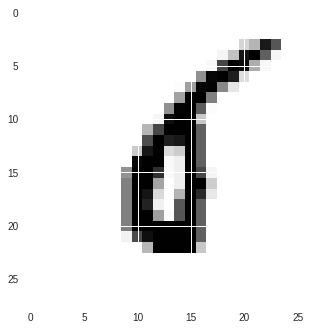

Prediction: 1


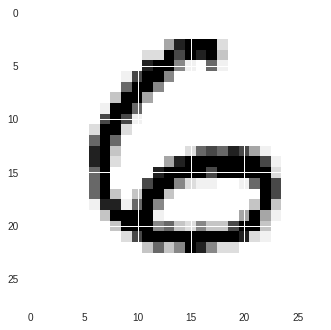

Prediction: 6


In [16]:
import matplotlib.pyplot as plt

sampled_data = test_data.batch(1).shuffle(buffer_size=10000).take(5)
for image, label in sampled_data:
  plt.figure()
  plt.imshow(tf.reshape(image, (28, 28)))
  plt.show()
  logits = model(image, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int64)
  print("Prediction: %d" % prediction)

# Profiling

If you want to drill down into the performance characteristics of your code, you can use native Python profilers like [`cProfile`](https://docs.python.org/3/library/profile.html). In the next exercise, you'll do just that.

## Exercise!

This exercise does not require coding. If you have not completed the training exercise, replace `train_one_epoch` below with `_train_one_epoch`.

Run the below cell and inspect the printed profiles. What parts of the code appear to be hotspots or
bottlenecks? How does sorting the profile by total time compare to sorting it
by cumulative time?



In [17]:
import cProfile
import pstats

cProfile.run("train_one_epoch(model, training_data, optimizer)", "training_profile")

stats = pstats.Stats("training_profile").strip_dirs().sort_stats("tottime")
stats.print_stats(10)

stats.sort_stats("cumtime").print_stats(10)

Thu Jun  7 12:25:04 2018    training_profile

         92209 function calls (91817 primitive calls) in 3.446 seconds

   Ordered by: internal time
   List reduced from 672 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1080    2.552    0.002    2.552    0.002 {built-in method _pywrap_tensorflow_internal.TFE_Py_FastPathExecute}
       83    0.753    0.009    0.753    0.009 {built-in method _pywrap_tensorflow_internal.TFE_Py_Execute}
       16    0.006    0.000    1.019    0.064 network.py:736(_run_internal_graph)
       16    0.005    0.000    2.253    0.141 {built-in method _pywrap_tensorflow_internal.TFE_Py_TapeGradient}
     2321    0.004    0.000    0.007    0.000 abc.py:178(__instancecheck__)
      288    0.004    0.000    0.009    0.000 inspect.py:2092(_signature_from_function)
      878    0.004    0.000    0.005    0.000 ops.py:5936(__enter__)
      288    0.004    0.000    0.016    0.000 inspect.py:1079(getfullargspec